In [1]:
# !rm extras/MOD05_L2.A2005349.2125.061.2017294065400_stare.nc
# !createSidecarFile extras/MOD05_L2.A2005349.2125.061.2017294065400.hdf-1

In [2]:
import os
import glob
from time import process_time

import pystare as ps

import matplotlib as mpl
# mpl.rcParams['agg.path.chunksize'] = 10000
# mpl.rcParams['agg.path.chunksize'] = 10000000
# mpl.use("Agg")

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cf

import numpy
import shapely

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import geopandas

from netCDF4 import Dataset
from pyhdf.SD import SD, SDC

In [3]:
# Some helper functions for plotting & printing.

class figax_container(object):
    def __init__(self,figax):
        self.fig = figax[0]
        self.ax  = figax[1]
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options={'projection':ccrs.PlateCarree(),'transform':ccrs.Geodetic()}
        ,set_global=False
        ,set_coastlines=True
        ,show=True
        ,color=None
        ,lw=1
        ):

    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options))
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()
    else:
        ax = figax.ax
    
    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        figax.ax.triplot(siv_triang,c=color,transform=plot_options['transform'],lw=lw)
    
    if show:
        plt.show()
        
    return figax

def hex16(i):
    return "0x%016x"%i

def lonlat_from_coords(coords):
    tmp = numpy.array(coords)
    lat=tmp[:,1]
    lon=tmp[:,0]
    return lon,lat

km  = 1 # Unit of length
deg = 1 # Unit of angle

In [4]:
# Set up the projection and transformation
proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson() # Drives matplotlib bug.
# proj        = ccrs.Mollweide() # Drives matplotlib bug.
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5*default_dpi

In [5]:
class load05_stare(object):
    def __init__(self,file_name):
        self.file_name   = file_name
        self.ds          = Dataset(file_name)
        self.lat0        = self.ds['Latitude_1km'][:,:].flatten()
        self.lon0        = self.ds['Longitude_1km'][:,:].flatten()
        self.spatial_id0 = self.ds['STARE_index_1km'][:,:].flatten().astype(numpy.int64)
    def shape(self,key='Latitude_1km'):
        return self.ds[key].shape
    def cover(self,key='STARE_cover_1km'):
        return self.ds[key][:].astype(numpy.int64)

In [6]:
# Help for task-parallel computing
from dask.distributed import Client
def slam(client,action,data,partition_factor=1.5):
    np = sum(client.nthreads().values())
    print('slam: np = %i'%np)
    shard_bounds = [int(i*len(data)/(1.0*partition_factor*np)) for i in range(int(partition_factor*np))] 
    if shard_bounds[-1] != len(data):
        shard_bounds = shard_bounds + [-1]
    data_shards = [data[shard_bounds[i]:shard_bounds[i+1]] for i in range(len(shard_bounds)-1)]
    print('ds len:        ',len(data_shards))
    print('ds item len:   ',len(data_shards[0]))
    print('ds type:       ',type(data_shards[0]))
    # print('ds dtype:      ',data_shards[0].dtype)
    big_future = client.scatter(data_shards)
    results    = client.map(action,big_future)
    return results



In [7]:
if False:
    ds = Dataset('extras/MOD05_L2.A2005349.2125.061.2017294065400_stare.nc')
    lat0 = ds['Latitude_1km'][:,:].flatten()
    lon0 = ds['Longitude_1km'][:,:].flatten()
    spatial_id0 = ds['STARE_index_1km'][:,:].flatten().astype(numpy.int64)

In [8]:
MOD05_A20053492125 = load05_stare('extras/MOD05_L2.A2005349.2125.061.2017294065400_stare.nc')
ds          = MOD05_A20053492125.ds
lat0        = MOD05_A20053492125.lat0
lon0        = MOD05_A20053492125.lon0
spatial_id0 = MOD05_A20053492125.spatial_id0

In [9]:
print('ds shape: ',ds['Latitude_1km'].shape)

ds shape:  (406, 270)


In [10]:
def plot_segment(i0,i1,figax):
    lat = lat0[i0:i1]
    lon = lon0[i0:i1]
    spatial_id = spatial_id0[i0:i1]
    figax = hello_plot(spatial_id,figax=figax,show=False)
    figax.ax.scatter([lon],[lat],s=1,c='r')
    return figax
    


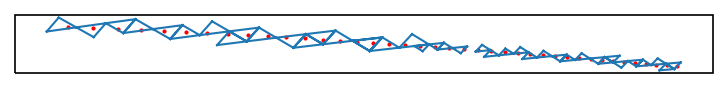

In [11]:
# Plot the trixel associated with the spatial index value
# figax = hello_plot(show=False)
figax = add_coastlines(figax_container(plt.subplots(subplot_kw={'projection':proj,'transform':transf})))
for i in range(1):
    figax = plot_segment(i*270,i*270+40,figax)
    # figax = plot_segment(i*270,i*270+406,figax)

mpl.rcParams['agg.path.chunksize'] = 100000
plt.show()

In [12]:
list(map(hex,spatial_id0[0:200:10]))

['0x300a70ed23bb2e69',
 '0x300b9b597040baa9',
 '0x300fb5c5678a1d4a',
 '0x300eaab5648e706a',
 '0x300917265413146a',
 '0x2c109499df1412ea',
 '0x2c11eee567863bca',
 '0x2c11badfe206eaab',
 '0x2c69cc171ccd7c2b',
 '0x2c6998222c02e70b',
 '0x2c695e89451225cb',
 '0x2c6e8b4f5ba4e64b',
 '0x2c6c8e6130f4d84b',
 '0x2c6ccb7b3a24cdeb',
 '0x2c4b2121e963f4ab',
 '0x2c4a5eb9525ccc8b',
 '0x2c4a75d44e0d8b0b',
 '0x2c5814048156f06b',
 '0x2c544dfe94f0514b',
 '0x2c55bf66e04a1ecb']

In [13]:
ds.variables.keys()

dict_keys(['Latitude_1km', 'Longitude_1km', 'STARE_index_1km', 'STARE_cover_1km'])

In [14]:
ds['Latitude_1km'].shape

(406, 270)

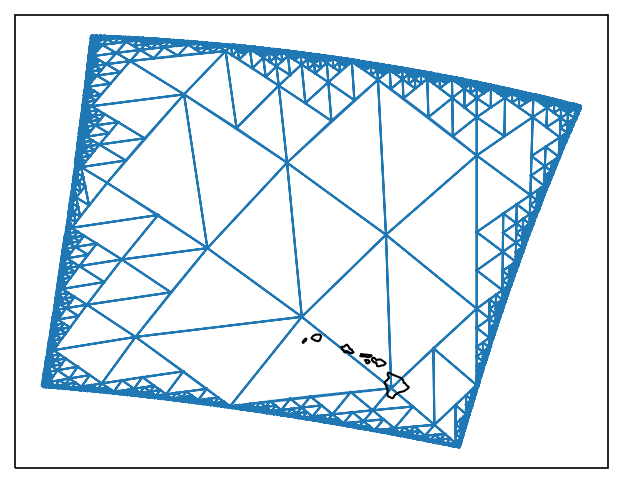

In [15]:
cover = ds['STARE_cover_1km'][:].astype(numpy.int64)
hello_plot(cover)

In [16]:
cover.size

7221

In [17]:
# Look for terminators, i.e. intervals.
for i in range(cover.size):
    if (cover[i] % 32) == 31:
        print('terminator found at ',i,cover[i])


In [18]:
id_intersect_cover = ps.intersects(cover,spatial_id0,1)
print('min id intersect cover: ',numpy.amin(id_intersect_cover))

min id intersect cover:  1


len lines0:  4133


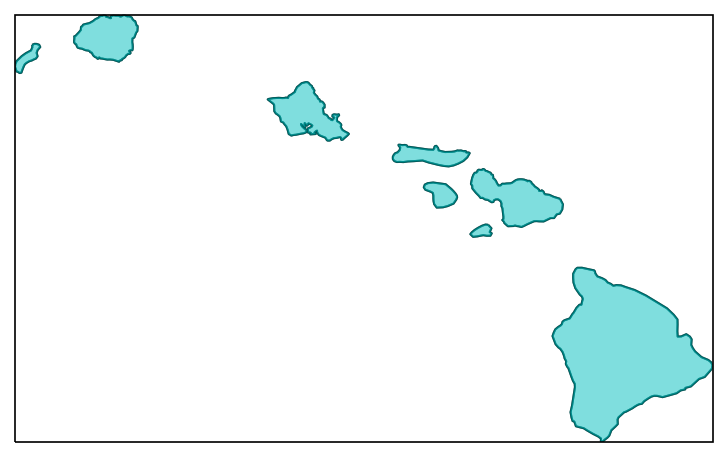

In [19]:
lines0 = list(cf.COASTLINE.with_scale('10m').geometries()) # Can be 10m, 50m, and 110m
print('len lines0: ',len(lines0))
if len(lines0) == 134:    # 110m
    line_idx = [107,108,109,110,111]
elif len(lines0) == 1428: # 50m
    line_idx = [802,803,804,805,806,807,808]
    # line_idx = [i for i in range(0,1399)]
elif len(lines0) == 4133: # 10m
    line_idx = [1672,1673,1675,1680,1685,1690,1699,1705]
else:
    print('cf.COASTLINE has unknown size or resolution')

#line_idx = [i for i in range(1700,1720)]
lines = []
for i in line_idx:
    lines = lines + [lines0[i]]
# lines = [lines0[1649],lines0[1672],lines0[1673],lines0[1675],lines0[1680],lines0[1685],lines0[1690]]

if True:
    multiline = shapely.geometry.MultiLineString(lines)
    figax = hello_plot(show=False,set_global=False)
    figax.ax.add_geometries(multiline,cf.COASTLINE.crs,color='c',alpha=0.5)
    figax.ax.set_extent(numpy.array(multiline.bounds)[[0,2,1,3]])
    # figax.ax.set_extent(numpy.array([-160.3, 18.5, -154.5, 22.5])[[0,2,1,3]])
    plt.show()
    
if False:
    for i in range(len(lines)):
        lines_ = [lines[i]]
        print(line_idx[i])
        multiline = shapely.geometry.MultiLineString(lines_)
        figax = hello_plot(show=False,set_global=False)
        figax.ax.add_geometries(multiline,cf.COASTLINE.crs,color='c',alpha=0.5)
        figax.ax.set_extent(numpy.array(multiline.bounds)[[0,2,1,3]])
        plt.show()

# lons,lats = lonlat_from_coords(list(lines[0].coords))


In [20]:
cover_resolution = 16
covers = []
for k in range(len(lines)):
#    lons,lats = lonlat_from_coords(list(lines[k].coords))
    covers = covers + [ps.from_polygon(shapely.geometry.polygon.orient(shapely.geometry.Polygon(lines[k]),1)
                                       ,resolution=cover_resolution,nonconvex=True)]
print(len(covers))

8


In [21]:
lines0 = list(cf.COASTLINE.geometries())
# [:]
print(len(lines0))

4133


iter:  0  cf.COASTLINE.geometries() index:  1672


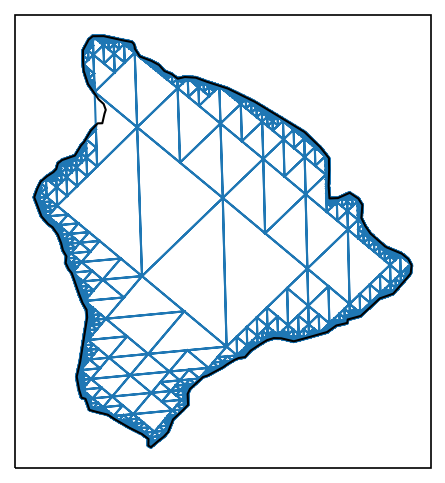

iter:  1  cf.COASTLINE.geometries() index:  1673


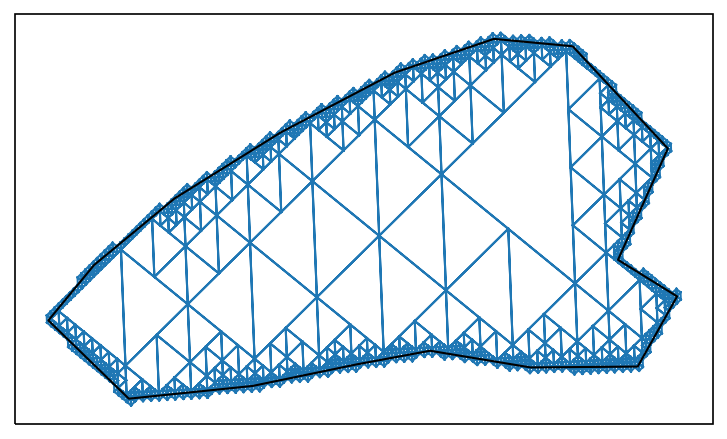

iter:  2  cf.COASTLINE.geometries() index:  1675


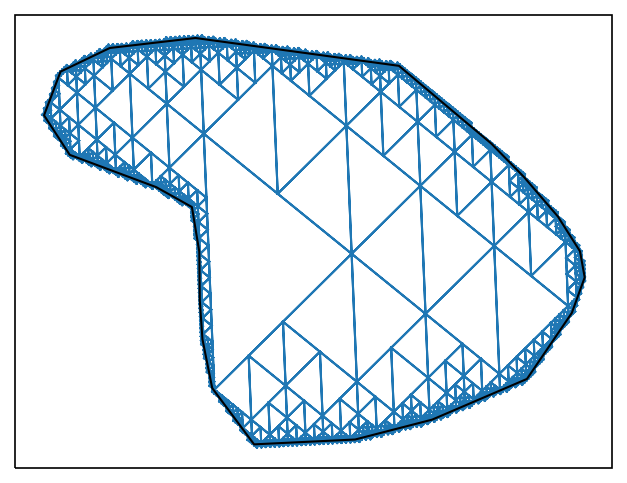

iter:  3  cf.COASTLINE.geometries() index:  1680


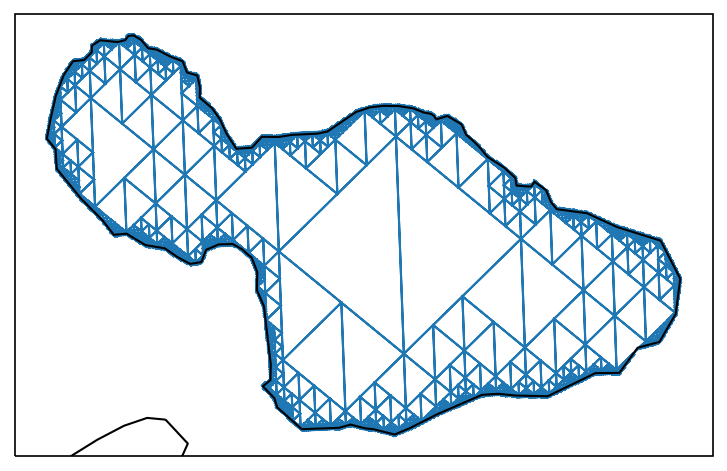

iter:  4  cf.COASTLINE.geometries() index:  1685


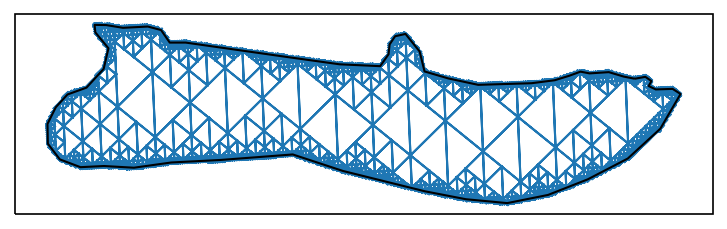

iter:  5  cf.COASTLINE.geometries() index:  1690


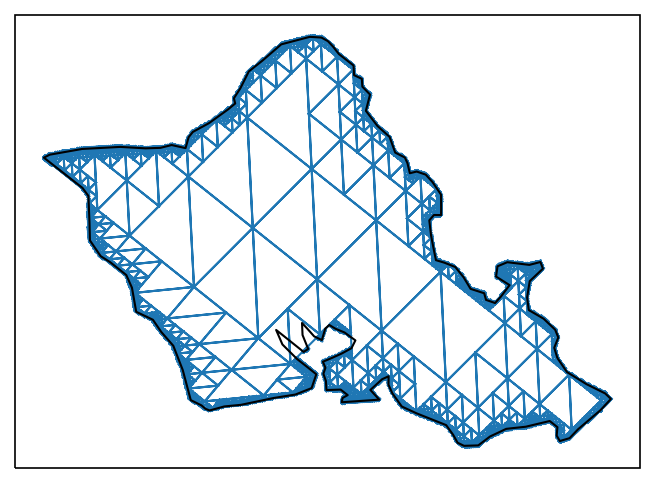

iter:  6  cf.COASTLINE.geometries() index:  1699


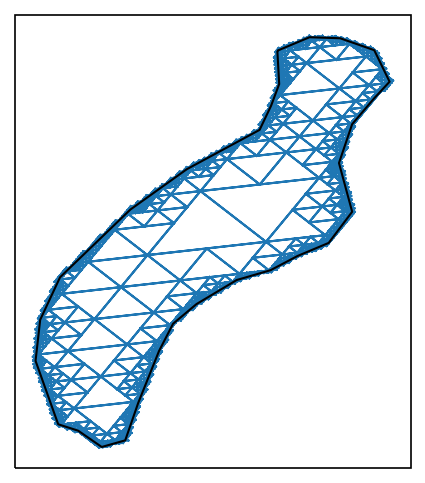

iter:  7  cf.COASTLINE.geometries() index:  1705


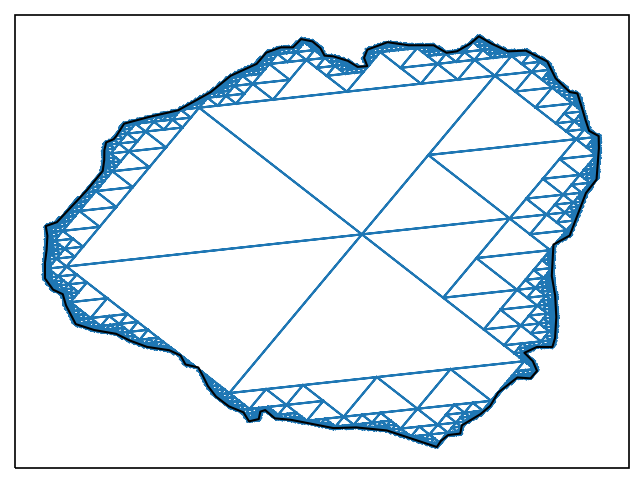

In [22]:

figax = None
# hello_plot(cover)
for i in range(len(covers)):
    print('iter: ',i,' cf.COASTLINE.geometries() index: ',line_idx[i])
    join = ps.intersects(cover,covers[i],1)
    # print('join size ',len(join))
    # print(join)
    # figax = hello_plot(covers[i],figax=None,show=False,set_global=False); plt.show()
    joined_cover = covers[i][numpy.where( join == 1 )]
    figax = hello_plot(joined_cover,figax=None,show=False,set_global=False); plt.show()


time:  7.592265999999995


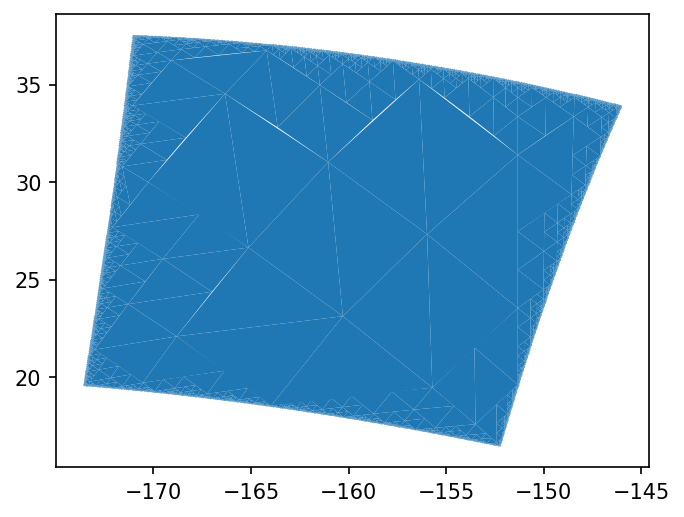

In [23]:
t0 = process_time()
geoms = ps.to_trixels(cover)
geopandas.GeoDataFrame({'geom':geoms}).set_geometry('geom').plot()
print('time: ',process_time()-t0)

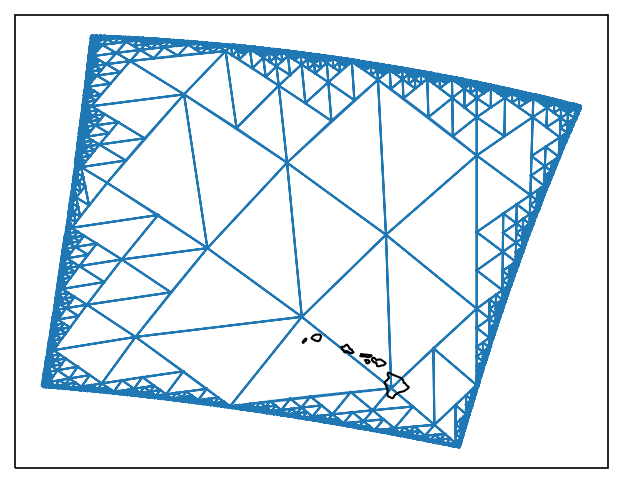

time:  6.428621000000007


In [24]:
t0 = process_time(); hello_plot(cover); print('time: ',process_time()-t0)

In [25]:
len(spatial_id0)

109620

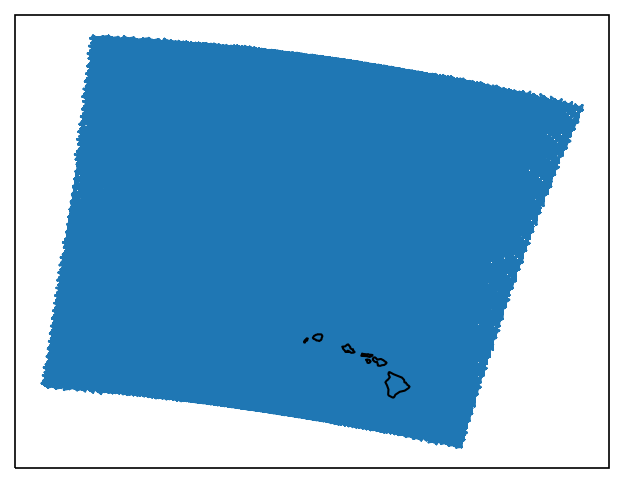

time:  98.168995


In [26]:
t0 = process_time(); hello_plot(spatial_id0); print('time: ',process_time()-t0)

time:  87.57852500000001


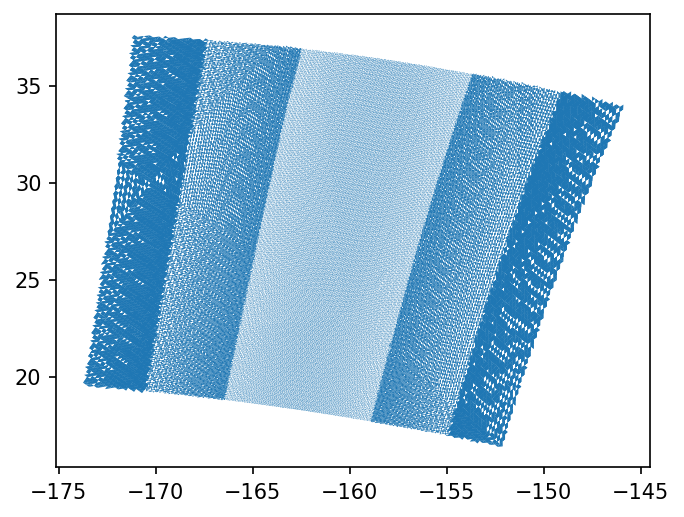

In [27]:
t0 = process_time()
geoms = ps.to_trixels(spatial_id0)
geopandas.GeoDataFrame({'geom':geoms}).set_geometry('geom').plot()
print('time: ',process_time()-t0)

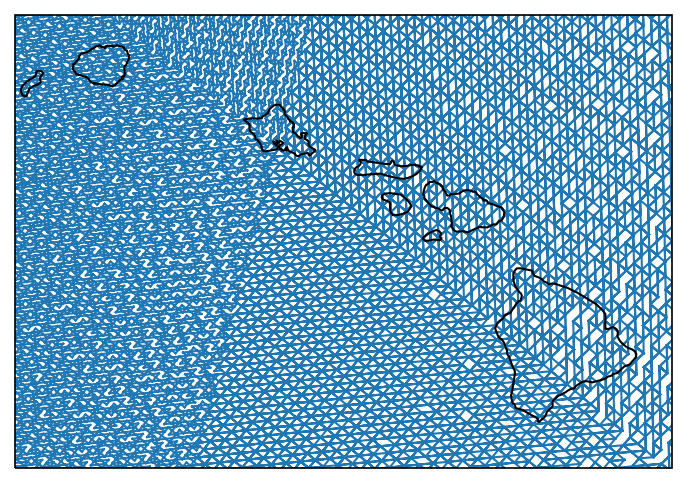

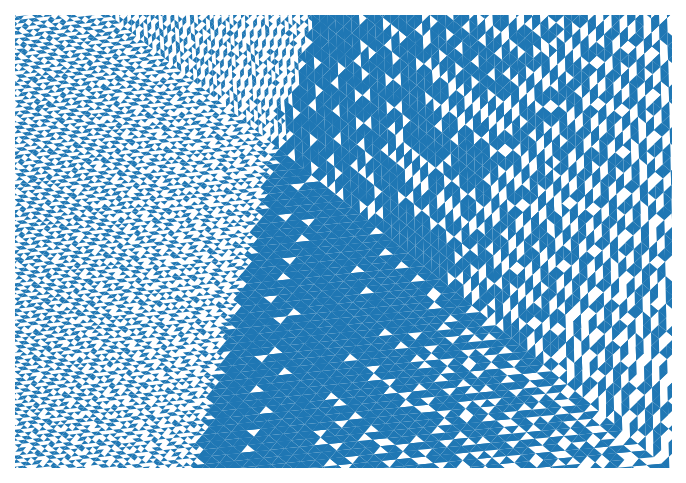

In [28]:
figax = hello_plot(show=False)
figax.ax.set_extent(numpy.array([-160.3, 18.5, -154.5, 22.5])[[0,2,1,3]])
figax = hello_plot(spatial_id0,figax=figax,show=False);

fig, ax = plt.subplots()
ax.set_ylim(18.5,22.5)
ax.set_xlim(-160.3,-154.5)
geoms = ps.to_trixels(spatial_id0)
plt.axis('off')
geopandas.GeoDataFrame({'geom':geoms}).set_geometry('geom').plot(ax=ax)
plt.show()



In [29]:
modis_file_name = "extras/MOD05_L2.A2005349.2125.061.2017294065400.hdf-1"
modis_geofile_name = "extras/MOD03.A2005349.2125.061.2017187042720.hdf"

modis_data    = SD(modis_file_name,    SDC.READ)
# modis_geodata = SD(modis_geofile_name, SDC.READ)

# geo_lat       = hdf_geo.select('Latitude').get()
# geo_lon       = hdf_geo.select('Longitude').get()

ds_wv_ir = modis_data.select('Water_Vapor_Infrared')
data     = ds_wv_ir.get()


In [30]:
data_f = data.flatten()
vmin = numpy.amin(data_f)
vmax = numpy.amax(data_f)

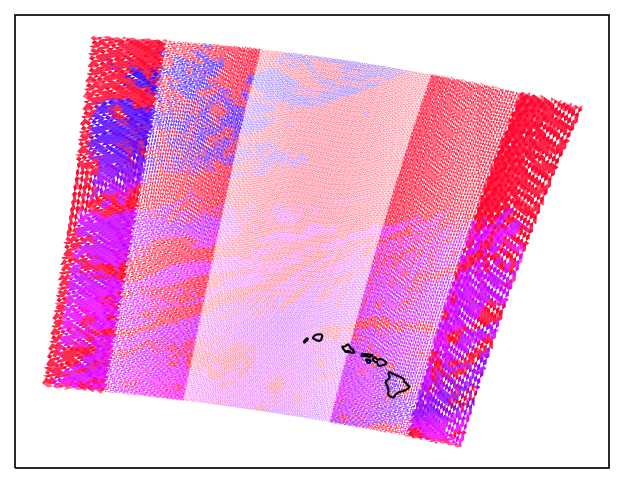

time:  40.54765900000001


In [31]:

t0 = process_time()
lli    = ps.triangulate_indices(spatial_id0)
triang = tri.Triangulation(lli[0],lli[1],lli[2])
figax = hello_plot(set_global=False,show=False)
# figax.ax.set_extent(numpy.array([-160.3, 18.5, -154.5, 22.5])[[0,2,1,3]])
figax.ax.tripcolor(
    triang
    ,facecolors=data_f
    ,edgecolors='k'
    ,lw=0
    ,shading='flat'
    ,vmin=vmin,vmax=vmax
    ,cmap = 'gist_rainbow'
    ,alpha = 0.65
)
plt.show()
print('time: ',process_time()-t0)

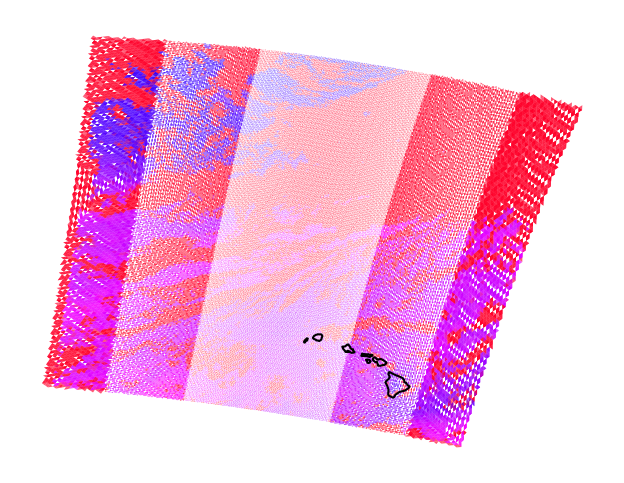

time:  108.36839200000003


In [32]:
t0 = process_time()
figax = hello_plot(show=False)
# ax.set_ylim(18.5,22.5)
# ax.set_xlim(-160.3,-154.5
geoms = ps.to_trixels(spatial_id0)
plt.axis('off')
geopandas.GeoDataFrame({'data':data_f
                        ,'geom':geoms}).set_geometry('geom').plot(column='data'
                                                                  ,ax=figax.ax
                                                                  ,vmin=vmin,vmax=vmax
                                                                  ,cmap='gist_rainbow'
                                                                  ,alpha=0.65
                                                                 )
plt.show()
print('time: ',process_time()-t0)

In [33]:
mod05_filelist = sorted(glob.glob('extras/armo/MOD05/*.nc'))

In [34]:
print('mod05_filelist len: ',len(mod05_filelist))

mod05_filelist len:  249


In [35]:
use_dask = True
if use_dask:
    client = Client()

slam: np = 16
ds len:         20
ds item len:    12
ds type:        <class 'list'>
dask processing done (s)  3.8098450000001094
visualization done (s)  1606.9116270000002


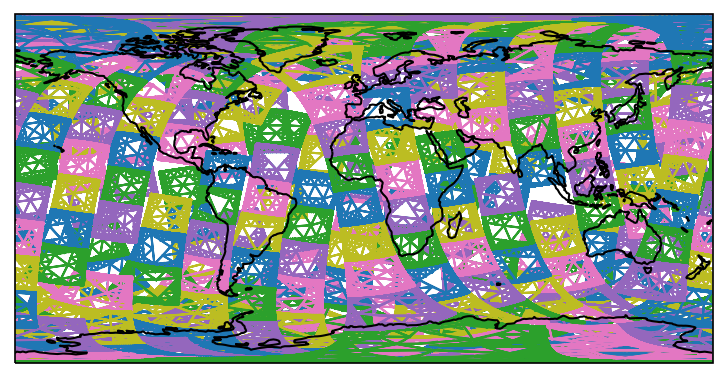

load & vis. with Dask processing time (s):  1635.315974


In [36]:
figax = hello_plot(show=False)
covers={}

if not use_dask:
    print('Not using dask')
    for f in mod05_filelist[0:40]:
        if f not in covers:
            covers[f] = load05_stare(f)
        hello_plot(covers[f].cover(),figax=figax,show=False)

def load05(inputs):
    lv_covers = {}
    for f in inputs:
        lv_covers[f] = load05_stare(f).cover()
    return lv_covers

if use_dask:
    # inputs=mod05_filelist[0:8]
    t0 = process_time()
    inputs=mod05_filelist
    result = slam(client,load05,inputs,partition_factor=1.25)
    client.gather(result)
    dt = process_time()-t0
    print('dask processing done (s) ',dt)

    t1 = process_time()
    for r in result:
        # print('r: ',r)
        rr = r.result()
        for f in rr:
            hello_plot(rr[f],figax=figax,show=False)
    dt = process_time()-t1
    print('visualization done (s) ',dt)

plt.show()

dt = process_time()-t0
print('load & vis. with Dask processing time (s): ',dt)

# print('result: ',result)


In [37]:
if False:
    if use_dask:
        client.close()